In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import subprocess
import os
import flopy.utils.binaryfile as bf
from MF6_BASIC import MF6_basic as mf

In [2]:
# define grid
def generate_grid(L, nrow, ncol):
    xx = np.linspace(0, L, nrow+1)
    yy = np.linspace(0, L, ncol+1)
    dx = xx[1] - xx[0]
    dy = yy[1] - yy[0]
    xs = (xx[0:-1] + xx[1::]) / 2
    ys = (yy[0:-1] + yy[1::]) / 2
    centers = np.zeros((nrow * ncol, 4)) # row col X Y
    t = 0
    for i in range(len(ys)):
        for j in range(len(xs)):
            centers[t, 0] = i + 1
            centers[t, 1] = j + 1
            centers[t, 2] = xs[j]
            centers[t, 3] = ys[::-1][i]
            t += 1
    #
    return xx, yy, dx, dy, xs, ys, centers

In [3]:
# CHD data
def generate_chd(nrow, ncol):
    chd_list = np.zeros((2*nrow, 4))
    chd_list[:, 0] = 1
    chd_list[0:nrow, 1] = np.arange(nrow) + 1
    chd_list[0:nrow, 2] = 1
    chd_list[0:nrow, 3] = 40.0
    chd_list[nrow::, 1] = np.arange(nrow) + 1
    chd_list[nrow::, 2] = ncol
    chd_list[nrow::, 3] = 60.0
    #
    return chd_list

In [4]:
# WEL data
def generate_wel(centers, w1_loc, w2_loc, w1_rate, w2_rate):
    # WEL list
    wel_list = []

    dist = (centers[:, 2] - w1_loc[0]) ** 2 + (centers[:, 3] - w1_loc[1]) ** 2
    dist = dist ** 0.5
    ind = np.where(dist == np.min(dist))[0]
    wel_list.append([1, centers[ind[0]][0], centers[ind[0]][1], w1_rate])

    dist = (centers[:, 2] - w2_loc[0]) ** 2 + (centers[:, 3] - w2_loc[1]) ** 2
    dist = dist ** 0.5
    ind = np.where(dist == np.min(dist))[0]
    wel_list.append([1, centers[ind[0]][0], centers[ind[0]][1], w2_rate])
    #
    return wel_list

In [5]:
# temporal discretization
def generate_td(nperiod):
    periodlist = [[1.0, 1, 1.0]] # start from steady state
    periodlist += [[1.0, 1, 1.0]] * nperiod # 1 day for each period
    #
    return periodlist    

In [6]:
# simulation
def simulator(modelpath, modelname, nrow, ncol, dx, dy, K, ss):
    # Wirte packages
    model = mf(modelpath, modelname, nrow, ncol, dx, dy, top = 10.0, bot = 0.0)
    model.write_dis()
    model.write_chd(chd_list)
    model.write_wel(wel_list, transient = 'True')
    model.write_npf(K)
    model.write_ic(initial_head = 20.0)
    model.write_oc()
    model.write_tdis(transient = 'True', periodlist = period_list)
    model.write_sto(ss)
    # Run model
    rdir = os.getcwd()
    os.chdir(modelpath)
    r = subprocess.run('mf6.exe')
    os.chdir(rdir)
    # load head
    hdobj = bf.HeadFile(modelpath + modelname + ".hed")
    #hdobj.list_records()
    rec_coll = np.zeros((nperiod+1, 1, nrow, ncol))
    for i in range(nperiod+1):
        rec_coll[i] = hdobj.get_data(idx=i)
    #
    return rec_coll

In [7]:
# setup parameters
modelpath = 'Ex1_transient/'
modelname = 'ex1_transient'
nperiod = 30 # days
L = 1000.0
nrow = 50
ncol = 50
K = 25.0
M = 10.0
ss = 3e-3
w1_loc = (250.0, 760.0)
w2_loc = (770.0, 380.0)
w1_rate = 5000.0
w2_rate = -3000.0

In [8]:
xx, yy, dx, dy, xs, ys, centers = generate_grid(L, nrow, ncol)
chd_list = generate_chd(nrow, ncol)
wel_list = generate_wel(centers, w1_loc, w2_loc, w1_rate, w2_rate)
period_list = generate_td(nperiod)

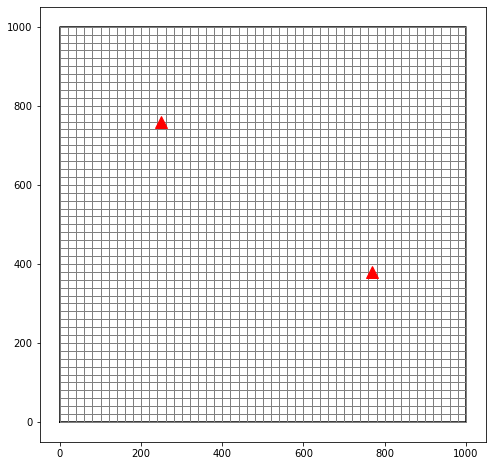

In [9]:
# plot grid
fig, ax = plt.subplots(1, figsize = (8, 8))
ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], color = 'black')
for i in yy:
    ax.plot([0, L], [yy, yy], color = 'grey', linewidth = 0.5)
for i in xx:
    ax.plot([xx, xx], [0, L], color = 'grey', linewidth = 0.5)
ax.plot(w1_loc[0], w1_loc[1], marker = 'o', markersize = 12, color = 'blue')
ax.plot(w2_loc[0], w2_loc[1], marker = '^', markersize = 12, color = 'red')

In [10]:
# Simulation
rec_coll = simulator(modelpath, modelname, nrow, ncol, dx, dy, K = 25.0, ss = 3e-3)

In [14]:
def animate_func(i):
    ax.clear()
    im = ax.imshow(rec_coll[i][0], cmap = 'rainbow', extent = (0, L, 0, L), vmin = 40.0, vmax = 60.0)
    ax.set_title('Time = {} day'.format(i), fontsize = 18)
    X, Y = np.meshgrid(xs, ys[::-1])
    Z = rec_coll[i][0]
    ct = ax.contour(X, Y, Z, levels = 10, colors = 'black', linewidths = 0.8)
    #if i == 0:
    #    fig.colorbar(im)

In [15]:
fig, ax = plt.subplots(1, figsize = (8, 8))
a = rec_coll[0]
im = ax.imshow(a[0], cmap = 'rainbow', extent = (0, L, 0, L))
fig.colorbar(im)
fig.suptitle(r'$S_s$ = {}'.format(ss) + ' $m^{-1}$', fontsize = 25)
anim = animation.FuncAnimation(fig, animate_func, frames = len(rec_coll), interval = 500)
anim.save('test_anim.gif')
plt.close(fig)

HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


In [13]:
SS_ls = [1e-4, 1e-3, 3e-3]
for i in range(3):
    rec_coll = simulator(modelpath, modelname, nrow, ncol, dx, dy, K = 25.0, ss = SS_ls[i])
    fig, ax = plt.subplots(1, figsize = (8, 8))
    a = rec_coll[0]
    im = ax.imshow(a[0], cmap = 'rainbow', extent = (0, L, 0, L))
    fig.colorbar(im)
    fig.suptitle(r'$S_s$ = {}'.format(SS_ls[i]) + ' $m^{-1}$', fontsize = 25)
    anim = animation.FuncAnimation(fig, animate_func, frames = len(rec_coll), interval = 500)
    anim.save('anim_ss_{}.gif'.format(SS_ls[i]))
    plt.close(fig)

    HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
